## Practical exercises. Part I

### Andrey Kravtsov

### The University of Chicago 

### email: kravtsov@uchicago.edu

In [1]:
# Preliminaries: set up plotting parameters
import numpy as np

# setup notebook for inline figures
%matplotlib inline
import matplotlib.pyplot as plt

# setup matplotlib parameters to make nicer plots
from codes.plot_utils import plot_pretty

## Exploring mass accretion histories (MAHs) of halos and approximation for mass accretion time

**Background.** Mass accretion rate of halos as a function of time are a foundation for understanding formation of galaxies, as it sets the overall accretion rate of matter. Physical processes affecting galaxy formation then modulate galaxy formation relative to this rate. 

**Goals of the exercise:** to explore mass assembly histories of halos for better qualitative understanding of material covered in my lecture 1 (see <a href="l01_peak_profile_MAH.ipynb">lecture 1 notebook</a>) and to try to come up with a useful approximation to the mass accretion rate of halos using these simulation results. 


First, set cosmology dictionary with parameters used in the simulations. The simulation suite used to produce these MAHs were done in the $\Lambda$CDM cosmology with parameters described in Tables 1 and 2 of <a href="http://adsabs.harvard.edu/abs/2015ApJ...799..108D">Diemer & Kravtsov (2015)</a>

In [5]:
from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
wmap_bolshoi_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.0469, 'sigma8': 0.82, 'ns': 0.95}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('wmap_bolshoi_cosmo', wmap_bolshoi_cosmo)
cosmo.interpolation = True


Read mass accretion histories of simulated halos. 

In [2]:
from codes.read_mah import read_halos

mah_fnames = ['MAH_M1e11_N20_L063.dat', 'MAH_M1e12_N20_L063.dat', 
              'MAH_M1e13_N20_L125.dat', 'MAH_M1e14_N20_L125.dat']
m0 = [1e11, 1e12, 1e13, 1e14]

#halos will be a list that contains information about evolutionary tracks of halos of different final mass
#returned by read_halos routine
halos = []
for mah_fname in mah_fnames: 
    halos.append(read_halos(r'data/'+mah_fname))


A routine to plot MAHs and its median (if needed) of simulated halos with a possible plot of a model that can be supplied in arrays <tt>tcr</tt>, <tt>Mcr</tt>

In [7]:
import matplotlib.ticker as mtick
from scipy.stats import binned_statistic

plot_pretty(dpi=200)

def plot_mah(tmin, tmax, Mmin, Mmax, tcr=None, Mcr=None, tmed_min=1.0, nmbins=20, plot_median=False, 
             plot_model=False, halos=None, cosmo=None, savefig=None):  
    """
    A routine to plot MAHs and its median (if needed) of simulated halos with a possible plot of a model
    
    Parameters:
    -----------
    tmin, tmax: floats, minimum and maximumm time range to use in the plot
    Mmin, Mmax: floats, minimum and maximum mass range to use in the plot
    tcr, Mcr:   1d numpy float arrays, containing times and masses for a model MAH 
                (should be None if no model is supplied)
    tmed_min:   float, minimum time to use when outputing median MAH
                this can be used to cutoff early part of MAH affected by limited mass resolution
                of simulation, which does not allow to track all MAHs to the same z equally well
    nmbins:     integer, the number of bins to use when constructing median MAH
    plot_median: logical, True if median is to be plotted and output by the routine
                if False, this routine will not output anything
    plot_model: logical, if True plot supplied model in tcr and Mcr
    
    halos:      object returned by the read_halos routine that contains evolution tracks of halos of similar 
                final mass. 
    cosmo:      colossus cosmology object
    savefig:    if not None, should be a string containing the name of the file into which to save the produced plot
    
    Returns:
    --------
    
    ltbmean, lmmed, lsmed: numpy float arrays, only if plot_median=True, the arrays contain values of log10(t) at 
                which median is evaluated, as well as log10 of the median MAH and rms variance of 
                of log10(M) within a given t bin
    
    
    """

    fig, ax = plt.subplots(1,2, figsize=(6,3))    
    xlims = [tmin, tmax]; ylims = [Mmin, Mmax]
    ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
    ax[0].set_xscale('log'); ax[0].set_yscale('log')
    ax[0].set_xlabel(r'$t\ \rm (Gyr)$'); ax[0].set_ylabel(r'$M(t)\ (M_\odot)$')
    
    if halos != None: 
        tminmax = -1.
        tha = []; mha = []
        for i, hd in enumerate(halos): 
            mvir = hd.mvir
            aexp = hd.scale_factor
            zh = 1./aexp - 1.
            th = cosmo.age(zh)
            tminmax = np.maximum(tminmax, th[0])
            tha.append(th); mha.append(mvir)
            if i==0: 
                ax[0].plot(th, mvir, c='mediumpurple', lw = 1.0, label=r'$\rm simulations$')
                ax[1].plot(th, mvir, c='mediumpurple', lw = 1.0, label=r'$\rm simulations$')
            else:
                ax[0].plot(th, mvir, c='mediumpurple', lw = 1.0)
                ax[1].plot(th, mvir, c='mediumpurple', lw = 1.0)

        if plot_median: 
            tha = np.concatenate(tha, axis=0); mha = np.concatenate(mha, axis=0)
            tha = np.squeeze(tha); mha = np.squeeze(mha)
            mha = mha[tha>tmed_min]; tha = tha[tha>tmed_min]
            lta = np.log10(tha); 
            lma = np.log10(mha) #- np.log10(Mhz0)
            # median
            lmmed, ltbedges, ltbins = binned_statistic(lta, lma, statistic='median', bins=nmbins)
            lsmed, ltbedges, ltbins = binned_statistic(lta, lma, statistic='std', bins=nmbins)
            ltbmean = 0.5*(ltbedges[1:] + ltbedges[:-1])

            ax[0].plot(10.**ltbmean, 10.**lmmed, lw=2.0, c='darkslateblue')
            ax[1].plot(10.**ltbmean, 10.**lmmed, lw=2.0, c='darkslateblue')
    if plot_model:
        ax[0].plot(tcr, Mcr,  c='darkslateblue', lw = 2.0, label=r'$\mathrm{peak\ collapse}$')
    ax[0].grid(ls=':', c='lightgray')
    #
    ax[1].set_xlim(tmin,tmax); ax[1].set_ylim(ylims)
    ax[1].set_yscale('log')
    ax[1].set_xlabel(r'$t\ \rm (Gyr)$'); #ax[1].set_ylabel(r'$M(t)\ (M_\odot)$')
    if plot_model:
        ax[1].plot(tcr, Mcr,  c='darkslateblue', lw = 2.0, label=r'$\mathrm{peak\  collapse}$')
    ax[0].legend(frameon=False,loc='upper left', fontsize=9)
    if savefig != None:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()
    
    if plot_median: 
        return ltbmean, lmmed, lsmed
    else:
        return

In [9]:
# prepare arrays for median MAH log10(t), log10(M)_median, and rms of log10(M(t))
nbmed = 20

ltmed = np.zeros((np.size(mah_fnames), nbmed))
lmmed = np.zeros_like(ltmed)
lsmed = np.zeros_like(ltmed)

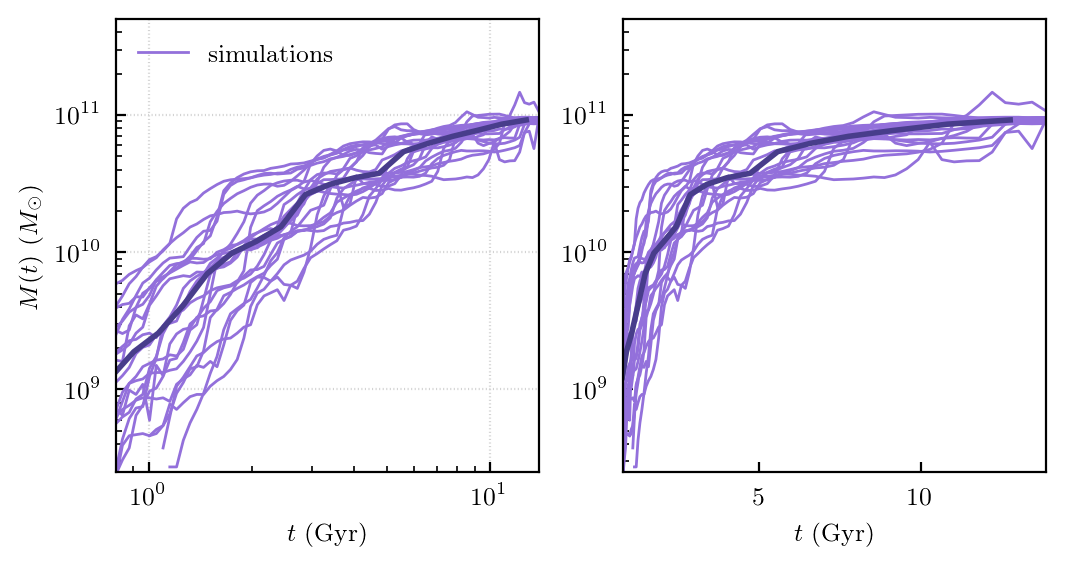

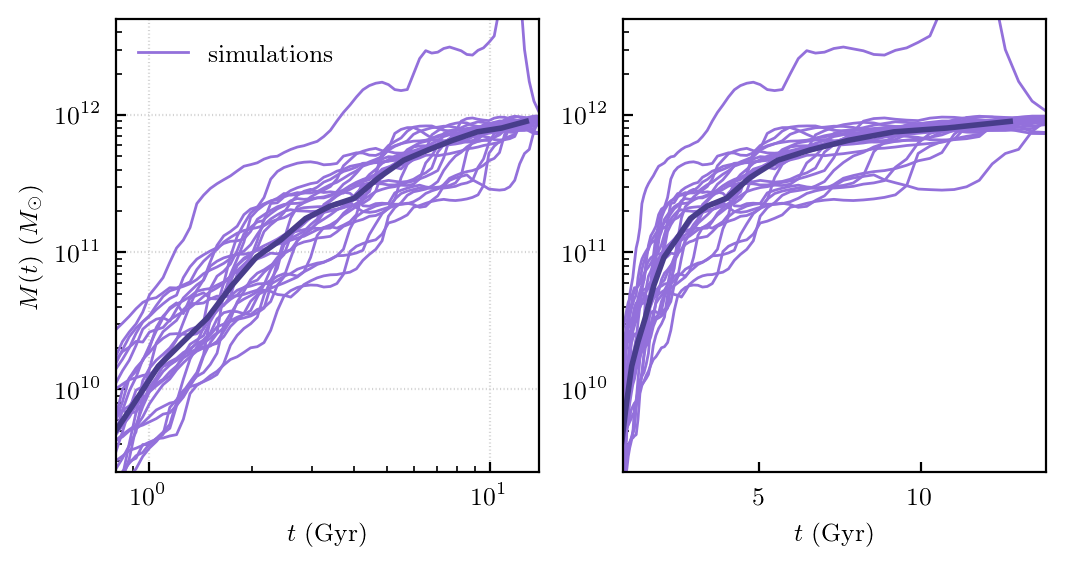

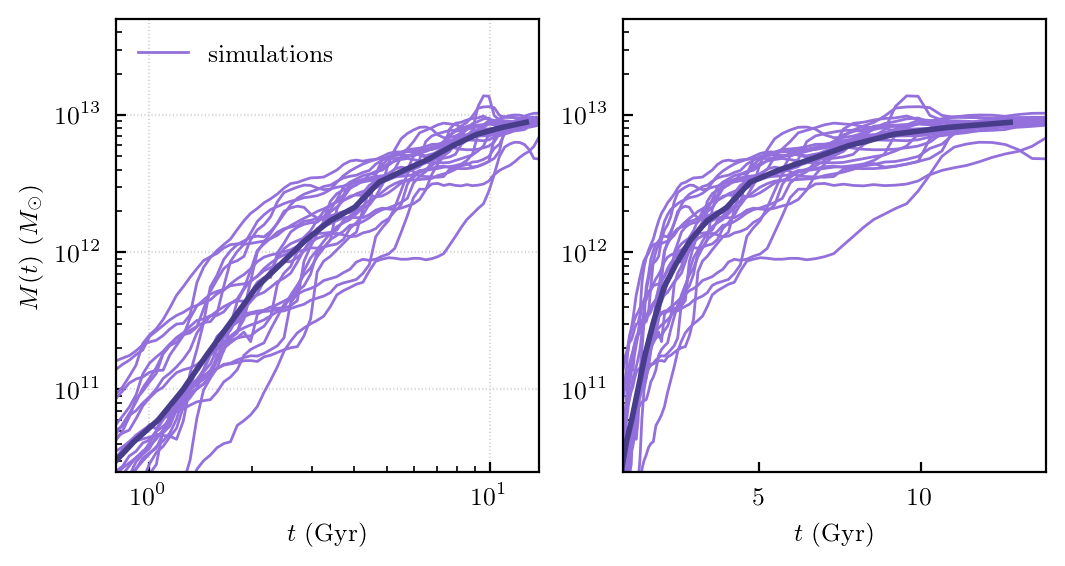

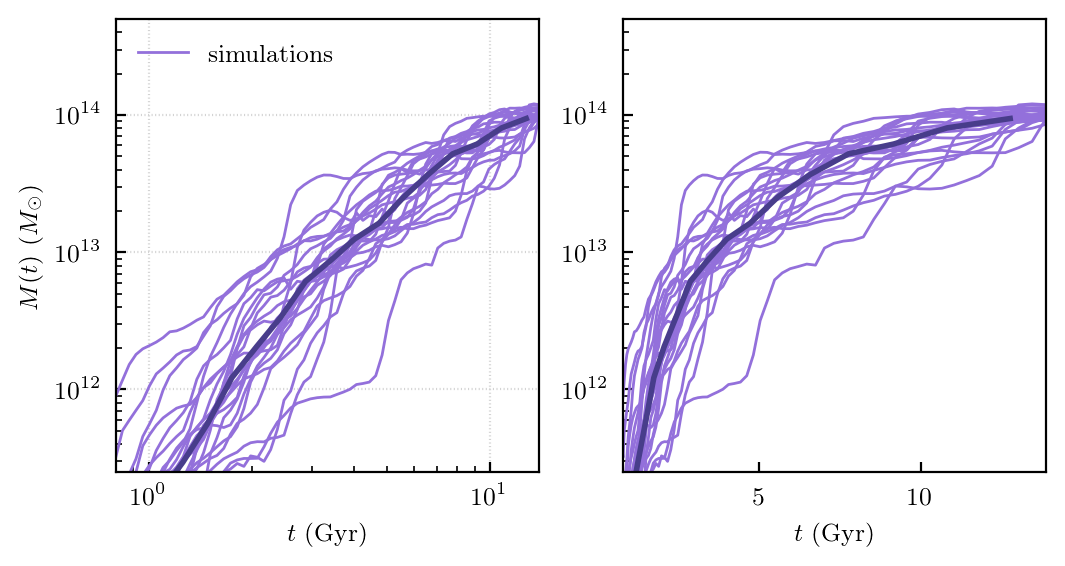

In [10]:

plot_median = True
for i, md in enumerate(m0):
    tmin = 0.8; tmax = cosmo.age(0.)
    Mmax = 5. * md
    Mmin = 5.e-4 * Mmax
    ltmed[i], lmmed[i], lsmed[i] = plot_mah(tmin, tmax, Mmin, Mmax, tcr=None, Mcr=None, tmed_min=0.5, 
                                            plot_median=plot_median, halos=halos[i], cosmo=cosmo, savefig=None)



Plot median MAHs on the same plot, but normalize each one to the final mass of the object, $M(z=0)$. 

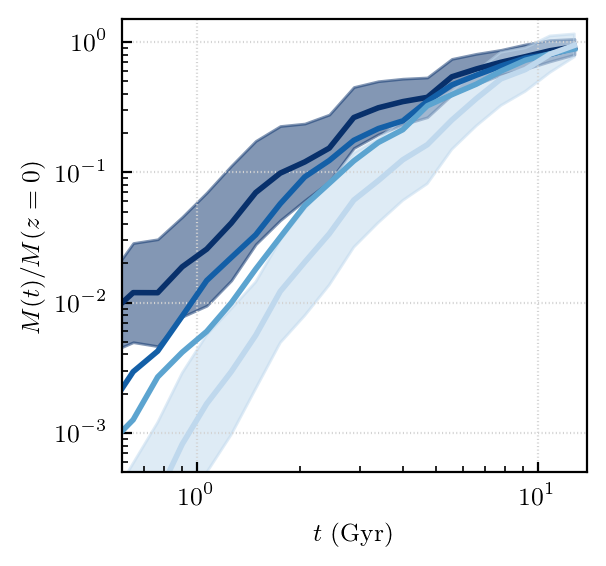

In [13]:
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, ax = plt.subplots(1,1, figsize=(3,3))    
xlims = [0.6, tmax]; ylims = [5.e-4, 1.5]
ax.set_xlim(xlims); ax.set_ylim(ylims)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$t\ \rm (Gyr)$'); ax.set_ylabel(r'$M(t)/M(z=0)$')

# this bit of codde prepares colors on a blue scale to be used for different masses
cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)
nc = np.zeros_like(m0)
for i, md in enumerate(np.log10(m0)): nc[i] = np.int(6.*(15.0-md))
color = scalarmap.to_rgba(nc)

# now plot
for i, md in enumerate(m0):
    ax.plot(10.**ltmed[i], 10.**lmmed[i]/md, color=color[i], lw=2)
    if (i==0) or (i==3): 
        ax.fill_between(10.**ltmed[i], 10.**(lmmed[i]-lsmed[i])/md, 10.**(lmmed[i]+lsmed[i])/md, 
                     color=color[i], alpha=0.5, label=r'$\pm\mathrm{dispersion}$')
        
ax.grid(ls=':', c='lightgray')
plt.show()

Then smooth them a bit with a smoothing spline using scipy's <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html">UnivariateSplit</a> routine. Be careful with the <tt>s</tt> parameter of this routine, as results are very sensitive to it!

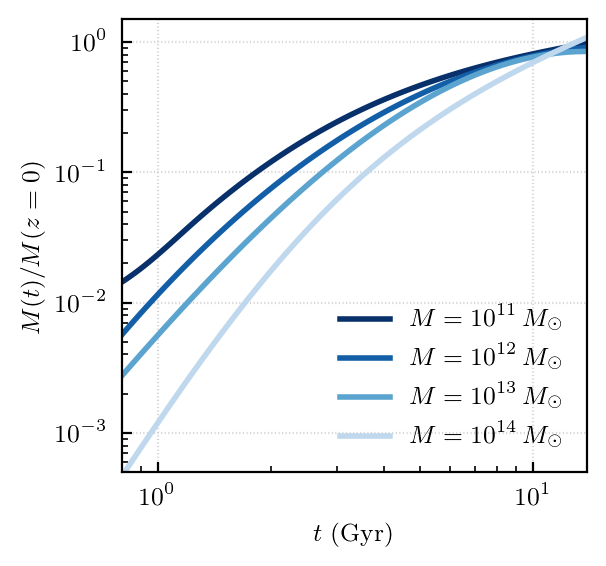

In [15]:
from scipy.interpolate import UnivariateSpline

fig, ax = plt.subplots(1,1, figsize=(3,3))    
xlims = [0.8, tmax]; ylims = [5.e-4, 1.5]
ax.set_xlim(xlims); ax.set_ylim(ylims)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$t\ \rm (Gyr)$'); ax.set_ylabel(r'$M(t)/M(z=0)$')

ltb = np.linspace(np.log10(tmin), np.log10(tmax), 100)

for i, lmd in enumerate(np.log10(m0)):
    
    mspl = UnivariateSpline(ltmed[i], lmmed[i]-lmd, s=0.025)
    ax.plot(10.**ltb, 10.**mspl(ltb), color=color[i], lw=2, label = r'$M = 10^{%.0f}\, M_\odot$'%(lmd))

ax.legend(frameon=False,loc='lower right', fontsize=9)
ax.grid(ls=':', c='lightgray')
plt.show()

This figure plots mass accretion time scale $\tau_{\rm acc}=M(t)/\dot{M}(t)$ for the smoothed medians constructed for simulated halos and compares them to a model presented in <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...753...16K/abstract">Krumholz & Dekel (2012)</a>, based on earlier work by Neistein and Dekel. 

$$\dot{M}=  1.06\times 10^{12}\ M_\odot  \left(\frac{M}{10^{12}\ M_\odot}\right)^{1.14}\frac{\dot{D}_+(t)}{D^2_+(t)},
$$

where $D_+(t)$ is the linear growth factor for a given cosmology. 

**Task 1.** The model by Neistein and Dekel was calibrated using analyses of simulations that used different halo finder (Friends-of-Friends) and mass definition and was motivated by a different physical model than that presented in lecture 1. Examine the differences between MAHs of simulated halos and the model. Try to modify parameters of this model so that it better matches simulation results.

***Hint:*** focus on agreement of the model and simulation results at intemediate epochs (say, $t\sim 2-10$ Gyrs) where shape of median MAHs is determined most accurately. 

**Task 2.** Can you come up with a different phenomenological parametric model that can better match simulation results than the model above? 


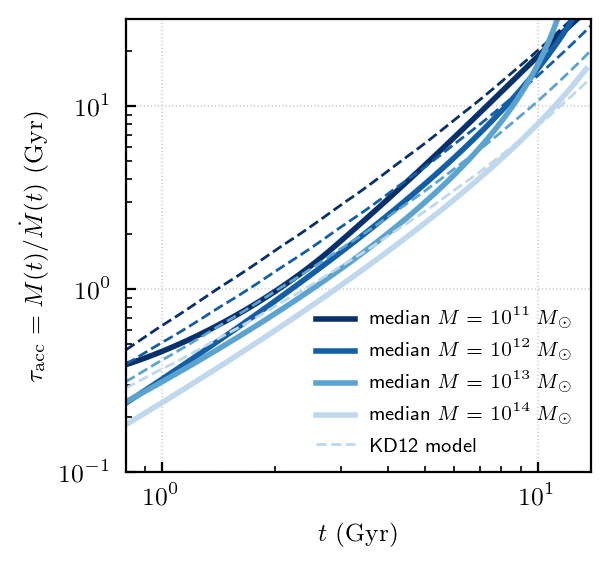

In [44]:
fig, ax = plt.subplots(1,1, figsize=(3,3))    
xlims = [0.8, tmax]; ylims = [0.1, 30.]
ax.set_xlim(xlims); ax.set_ylim(ylims)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$t\ \rm (Gyr)$'); ax.set_ylabel(r'$\tau_{\rm acc}=M(t)/\dot{M}(t)\rm\ (Gyr)$')

# the quantities elow are computed 
# grid of z corresponding to grid of time we used 
z = cosmo.age(10.**ltb, inverse=True)
# linear growth rate in this cosmology as a function of z
Dt = cosmo.growthFactor(z)
# time derivative of the growth rate computed as dD/dz * dz/dt using colossus routines
dDdt = cosmo.growthFactor(z, derivative=1) * cosmo.age(10.**ltb, derivative=1, inverse=True)

for i, lmd in enumerate(np.log10(m0)):
    # construct a smoothed spline for the median MAHs normalized by log10(M(z=0))
    mspl = UnivariateSpline(ltmed[i], lmmed[i]-lmd, s=0.035)
    # dlog M/dlog t
    mspld = mspl.derivative()
    # accretion time scale M / dM/dt
    mmdot = 10.**mspl(ltb) * 10.**ltb / (10.**mspl(ltb)*mspld(ltb)) 
    # the Krumholz & Dekel 2012 model parametrization
    mmdotmodel = Dt**2/dDdt * (10.**(lmd+mspl(ltb))/1.e12)**(-0.14) / 1.06 
    if i == 3: 
        label = 'KD12 model'
    else:
        label = None
    ax.plot(10.**ltb[:-1], mmdot[:-1] , color=color[i], lw=2, label=r'median $M = 10^{%.0f}\, M_\odot$'%(lmd))
    ax.plot(10.**ltb, mmdotmodel , ls='--', color=color[i], lw=1, label=label)
        
ax.grid(ls=':', c='lightgray')
plt.legend(frameon=False, loc='lower right', fontsize=7)
plt.show()

<b>Possible extra task.</b> You can test other approximations to $\dot{M}$ proposed and often used in the literature, e.g. approximation by <a href="http://adsabs.harvard.edu/abs/2010MNRAS.406.2267F">Fakhouri et al (2010)</a>:

$$
\left\langle\frac{dM}{dt}\right\rangle=4.61 \times 10^{10}\ M_\odot\,\mathrm{Gyr}^{-1}\left(\frac{M}{10^{12}\,M_\odot}\right)^{1.1}\times (1+1.11z)\sqrt{\Omega_{\rm m,0}(1+z)^3+\Omega_\Lambda}. 
$$

and <a href="http://adsabs.harvard.edu/abs/2015MNRAS.450.1521C">Correa et al. (2015)</a>

$$\left\langle\frac{dM}{dt}\right\rangle=7.16\times 10^{10}\ M_\odot\,\mathrm{yr}^{-1}\left(\frac{M}{10^{12}\,M_\odot}\right)\left(\frac{h}{0.7}\right) (0.75(1+z)-0.24)\sqrt{\Omega_{\rm m,0}(1+z)^3+\Omega_\Lambda}. 
$$

to convert $z$ to cosmic time in Gyrs, you can use colossus routine <tt>age</tt>

In [ ]:
# for t in Gyrs, given a single or vector of z, do 
t = cosmo.age(z)
